## Download Library

In [6]:
!pip install tensorflow
!pip install tensorflowjs
!pip install scikit-learn seaborn pillow matplotlib

## Import Library

In [6]:
# Import standard libraries
import os
import random
import shutil
import pathlib
import pandas as pd
import numpy as np
import matplotlib
import sklearn
# Import PIL for image processing
from PIL import Image

# Import TensorFlow and Keras libraries
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2

In [7]:
print(f"{'Numpy Version':20}: {np.__version__}")
print(f"{'Pandas Version':20}: {pd.__version__}")
print(f"{'Tensorflow Version':20}: {tf.__version__}")
print(f"{'TensorflowJS Version':20}: {tfjs.__version__}")
print(f"{'Matplotlib Version':20}: {matplotlib.__version__}")
print(f"{'Scikit-Learn Version':20}: {sklearn.__version__}")
print(f"{'Image Version':20}: {Image.__version__}")

Numpy Version       : 2.0.2
Pandas Version      : 2.2.2
Tensorflow Version  : 2.18.0
TensorflowJS Version: 4.22.0
Matplotlib Version  : 3.10.0
Scikit-Learn Version: 1.6.1
Image Version       : 11.2.1


In [8]:
# Download Dataset
!mkdir ~/.kaggle
!echo '{"username":"yusriyahim","key":"SECRET-KEY"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d moltean/fruits
!unzip fruits.zip

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_277.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_281.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_285.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_289.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_29.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_33.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_37.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_41.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_45.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_49.j

## Merged Dataset

In [9]:
import os
import shutil

# Define the paths
training_dataset_path = '/content/fruits-360_original-size/fruits-360-original-size/Training'
test_dataset_path = '/content/fruits-360_original-size/fruits-360-original-size/Test'
validation_dataset_path = '/content/fruits-360_original-size/fruits-360-original-size/Validation'
dataset_path = '/content/fruits'

def copy_contents(src, dst):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            if not os.path.exists(d):
                os.makedirs(d)
            copy_contents(s, d)
        else:
            shutil.copy2(s, d)

# Create the new directory for the merged dataset
os.makedirs(dataset_path, exist_ok=True)

# Copy contents into the new directory
copy_contents(training_dataset_path, dataset_path)
copy_contents(validation_dataset_path, dataset_path)
copy_contents(test_dataset_path, dataset_path)

## Show Images

In [14]:
# List extentions
allowed_extensions = ['.png', '.jpg', '.jpeg']

label = []
path = []

for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        if os.path.splitext(filename)[-1].lower() in allowed_extensions:
            label.append(os.path.split(dirname)[-1])
            path.append(os.path.join(dirname, filename))

# Create df
df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

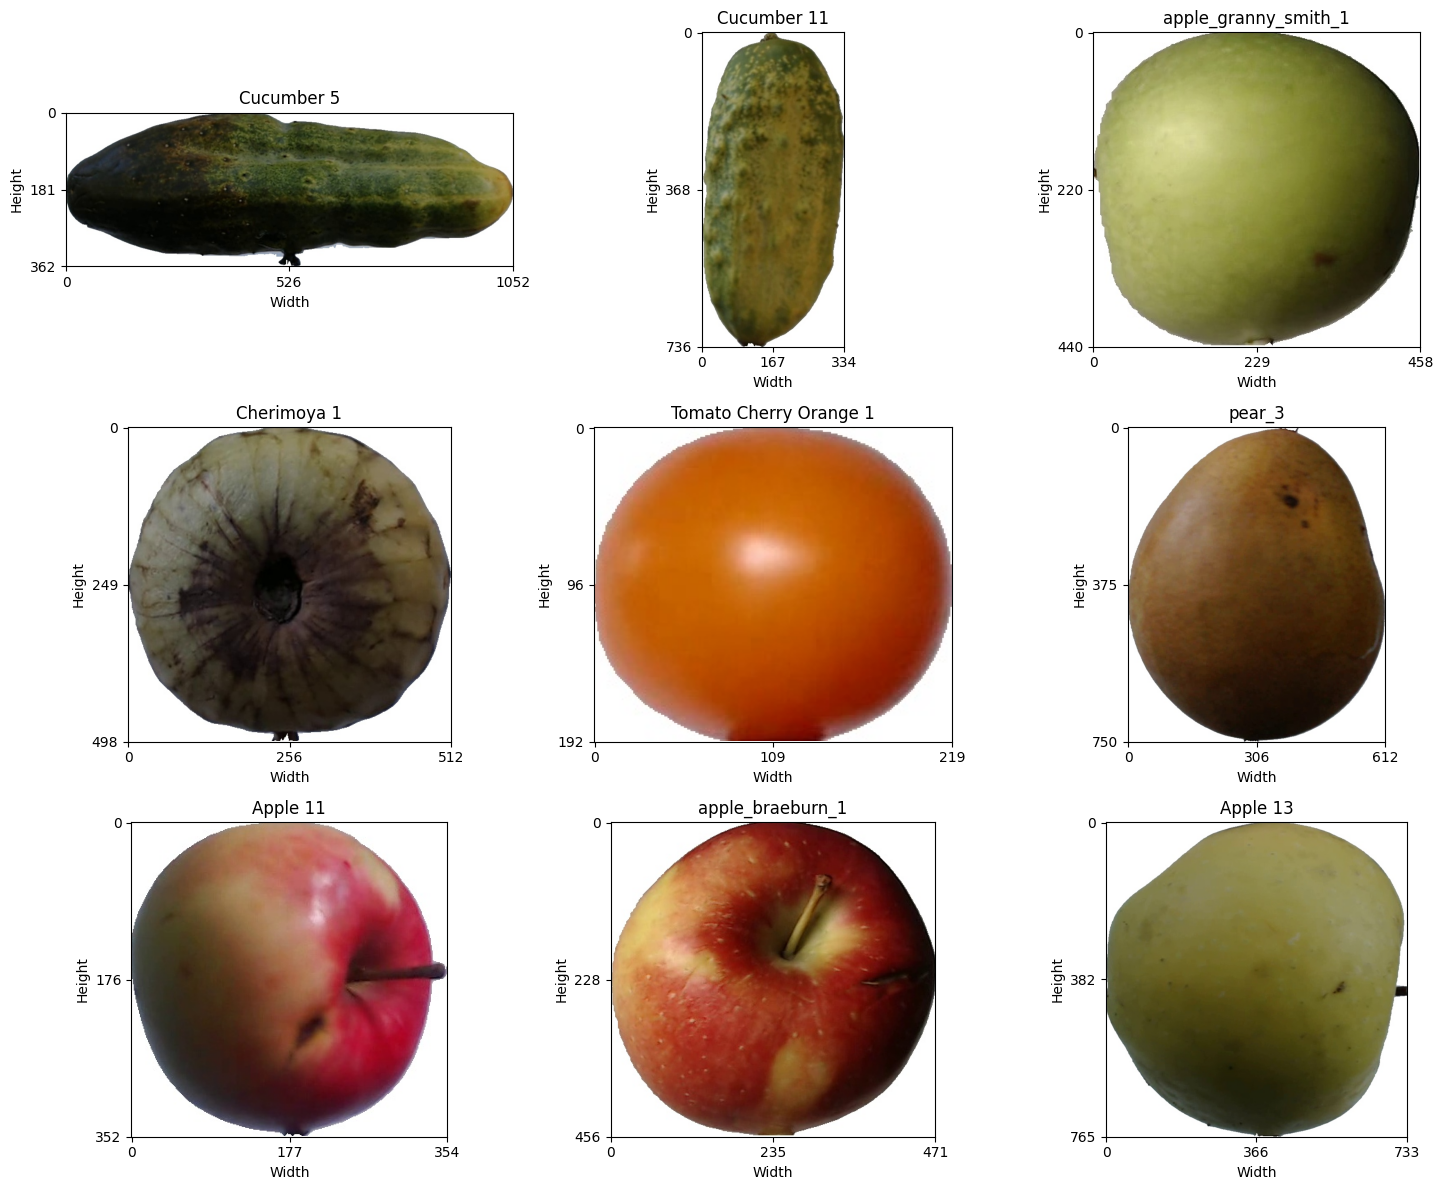

path       label
0   /content/fruits/Cucumber 5/r2_41.jpg  Cucumber 5
1   /content/fruits/Cucumber 5/r2_36.jpg  Cucumber 5
2  /content/fruits/Cucumber 5/r2_253.jpg  Cucumber 5
3   /content/fruits/Cucumber 5/r2_62.jpg  Cucumber 5
4  /content/fruits/Cucumber 5/r1_129.jpg  Cucumber 5

In [16]:
unique_labels = df['label'].unique()[:9]

plt.figure(figsize=(15,12))
for id, unique_label in enumerate(unique_labels):
    plt.subplot(3, 3, id+1)
    img_path = df[df['label'] == unique_label].iloc[0, 0]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(unique_label)

    height, width = img.shape[:2]
    plt.xticks([0, width//2, width], [0, width//2, width])
    plt.yticks([0, height//2, height], [0, height//2, height])
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.axis('on')

plt.tight_layout()
plt.show()
df.head()

### Show Class

In [21]:
# check value count jumlah gambar
pd.set_option('display.max_rows', None)
print(df['label'].value_counts())

label
Cherimoya 1                  1292
Quince 4                      999
Apple 17                      975
Quince 3                      973
Apple 19                      970
Quince 2                      969
Tomato 8                      961
Cucumber 10                   960
Tomato 9                      959
Cactus fruit red 1            949
Cucumber 5                    942
apple_hit_1                   936
Avocado Black 1               933
Avocado Green 1               933
Tomato 7                      931
Cherry 3                      930
Pistachio 1                   930
Cherry 4                      930
Apple 10                      930
Cactus fruit green 1          930
Apple 13                      930
Apple worm 1                  927
Cherry Rainier 2              927
Apple 9                       925
Blackberrie not rippen 1      925
Apple 7                       923
Cherry 5                      921
Tomato 10                     919
Apple 8                       915
Cherry R

# Data Preprocessing

Secara total terdapat 85 kelas buah dan sayur yang berbeda. Pada kriteria penilaian dicoding jumlah minimal dataset berisi 10.000 gambar sehingga pada proyek kali ini hanya akan dipilih 23 kelas agar meringangkan beban kerja. Kelas yang dipilih dan jumlah akhir dari dataset adalah sebagai berikut:
*   apple_golden_3
*   apple_red_1
*   apple_rotten_1
*   Avocado Green 1
*   Banana 3
*   Beans 1
*   Blackberrie 1
*   Cabbage red 1
*   cabbage_white_1
*   Cactus fruit red 1
*   Caju seed 1
*   carrot_1
*   Cherimoya 1
*   Cherry Rainier 3
*   Cherry Wax Red 2
*   Cucumber 5
*   eggplant_long_1
*   Gooseberry 1
*   pear_3
*   Pistachio 1
*   Quince 4
*   Tomato Cherry Maroon 1
*   zucchini_1


In [22]:
def count_images(target_classes, directory):
  class_counts = {}
  for class_name in target_classes:
    class_path = os.path.join(directory, class_name)
    if os.path.isdir(class_path):
      count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
      class_counts[class_name] = count
    else:
      class_counts[class_name] = 0

  return class_counts

# Define the target classes
target_classes = [
    'apple_golden_3',
    'apple_red_1',
    'apple_rotten_1',
    'Avocado Green 1',
    'Banana 3',
    'Beans 1',
    'Blackberrie 1',
    'Cabbage red 1',
    'cabbage_white_1',
    'Cactus fruit red 1',
    'Caju seed 1',
    'carrot_1',
    'Cherimoya 1',
    'Cherry Rainier 3',
    'Cherry Wax Red 2',
    'Cucumber 5',
    'eggplant_long_1',
    'Gooseberry 1',
    'pear_3',
    'Pistachio 1',
    'Quince 4',
    'Tomato Cherry Maroon 1',
    'zucchini_1'
]

# Count images for the target classes in the merged dataset directory
image_counts = count_images(target_classes, dataset_path)

# Print the results
print("Number of images for the target classes:")
for class_name, count in image_counts.items():
  print(f"{class_name}: {count}")

Number of images for the target classes:
apple_golden_3: 632
apple_red_1: 618
apple_rotten_1: 638
Avocado Green 1: 933
Banana 3: 309
Beans 1: 310
Blackberrie 1: 600
Cabbage red 1: 198
cabbage_white_1: 191
Cactus fruit red 1: 949
Caju seed 1: 301
carrot_1: 201
Cherimoya 1: 1292
Cherry Rainier 3: 914
Cherry Wax Red 2: 602
Cucumber 5: 942
eggplant_long_1: 320
Gooseberry 1: 620
pear_3: 287
Pistachio 1: 930
Quince 4: 999
Tomato Cherry Maroon 1: 402
zucchini_1: 320


In [30]:
def count_images(base_path, target_class=target_classes):
    total_count = 0
    target_class_count = 0

    for root, dirs, files in os.walk(base_path):
        total_count += len(files)
        for class_name in target_class:
            if class_name.lower() in root.lower():
                target_class_count += len(files)
                break

    return total_count, target_class_count

# Path to the main folder
base_path = "/content/fruits"
total_count, target_class_count = count_images(base_path)

print(f"Jumlah total gambar dalam dataset: {total_count}")
print(f"Jumlah gambar dalam target kelas: {target_class_count}")

Jumlah total gambar dalam dataset: 56763
Jumlah gambar dalam target kelas: 13508


In [32]:
def copy_folders(base_path, target_folder="dataset", target_class=target_classes):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            # Check if any of the target class names (case-insensitive) are in the directory name
            if any(tc.lower() in dir_name.lower() for tc in target_class):
                source_path = os.path.join(root, dir_name)
                dest_path = os.path.join(target_folder, dir_name)
                if not os.path.exists(dest_path):
                    shutil.copytree(source_path, dest_path)
                    print(f"Menyalin {source_path} ke {dest_path}")

# Path to the main folder
base_path = "/content/fruits"

# Path to destination folder
target_folder = "/content/dataset"

copy_folders(base_path, target_folder)

Menyalin /content/fruits/Cucumber 5 ke /content/dataset/Cucumber 5
Menyalin /content/fruits/Cherimoya 1 ke /content/dataset/Cherimoya 1
Menyalin /content/fruits/pear_3 ke /content/dataset/pear_3
Menyalin /content/fruits/Banana 3 ke /content/dataset/Banana 3
Menyalin /content/fruits/Tomato Cherry Maroon 1 ke /content/dataset/Tomato Cherry Maroon 1
Menyalin /content/fruits/apple_rotten_1 ke /content/dataset/apple_rotten_1
Menyalin /content/fruits/carrot_1 ke /content/dataset/carrot_1
Menyalin /content/fruits/cabbage_white_1 ke /content/dataset/cabbage_white_1
Menyalin /content/fruits/Blackberrie 1 ke /content/dataset/Blackberrie 1
Menyalin /content/fruits/eggplant_long_1 ke /content/dataset/eggplant_long_1
Menyalin /content/fruits/Caju seed 1 ke /content/dataset/Caju seed 1
Menyalin /content/fruits/Pistachio 1 ke /content/dataset/Pistachio 1
Menyalin /content/fruits/Cactus fruit red 1 ke /content/dataset/Cactus fruit red 1
Menyalin /content/fruits/Cabbage red 1 ke /content/dataset/Cabbag

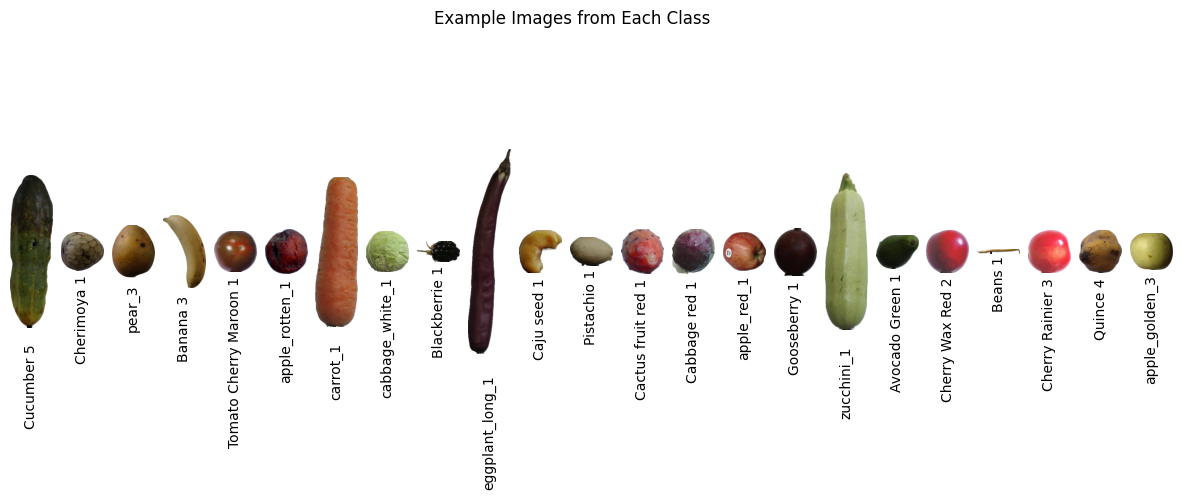

In [34]:
import random
def show_example_images(base_path):
    class_images = {}

    for root, dirs, files in os.walk(base_path):
        if files:
            class_name = os.path.basename(root)
            random_image = random.choice(files)
            class_images[class_name] = os.path.join(root, random_image)

    fig, axes = plt.subplots(1, len(class_images), figsize=(15, 5))
    fig.suptitle('Example Images from Each Class')

    for ax, (class_name, image_path) in zip(axes, class_images.items()):
        img = Image.open(image_path)
        ax.imshow(img)
        ax.text(0.5, -0.1, class_name, rotation=90, verticalalignment='top', horizontalalignment='center', transform=ax.transAxes)
        ax.axis('off')

    plt.show()

# Path ke folder utama
base_path = "/content/dataset"

show_example_images(base_path)

**Split Dataset**

In [35]:
# Split the dataset into train and test 8:2
def split_dataset(base_path, train_ratio=0.8):
    # Path for training and testing datasets
    train_path = os.path.join(base_path, 'train')
    test_path = os.path.join(base_path, 'test')

    # Create train and test folders if they don't exist yet
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    for root, dirs, files in os.walk(base_path):
        if root == base_path:
            continue

        class_name = os.path.basename(root)
        if class_name in ['train', 'test']:
            continue

        # Create class folders inside train and test
        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Shuffle files
        random.shuffle(files)
        split_index = int(train_ratio * len(files))
        train_files = files[:split_index]
        test_files = files[split_index:]

        # Move files to train folder
        for file in train_files:
            src_file = os.path.join(root, file)
            dst_file = os.path.join(train_class_path, file)
            shutil.move(src_file, dst_file)

        # Move files to test folder
        for file in test_files:
            src_file = os.path.join(root, file)
            dst_file = os.path.join(test_class_path, file)
            shutil.move(src_file, dst_file)

base_path = "/content/dataset"

split_dataset(base_path)

In [36]:
# Delete folders other than train and test folders
def delete_unwanted_folders(base_path, keep_folders=['train', 'test']):
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path) and item not in keep_folders:
            shutil.rmtree(item_path)
            print(f"Menghapus folder: {item_path}")

base_path = "/content/dataset"

delete_unwanted_folders(base_path)

Menghapus folder: /content/dataset/Cucumber 5
Menghapus folder: /content/dataset/Cherimoya 1
Menghapus folder: /content/dataset/pear_3
Menghapus folder: /content/dataset/Banana 3
Menghapus folder: /content/dataset/Tomato Cherry Maroon 1
Menghapus folder: /content/dataset/apple_rotten_1
Menghapus folder: /content/dataset/carrot_1
Menghapus folder: /content/dataset/cabbage_white_1
Menghapus folder: /content/dataset/Blackberrie 1
Menghapus folder: /content/dataset/eggplant_long_1
Menghapus folder: /content/dataset/Caju seed 1
Menghapus folder: /content/dataset/Pistachio 1
Menghapus folder: /content/dataset/Cactus fruit red 1
Menghapus folder: /content/dataset/Cabbage red 1
Menghapus folder: /content/dataset/apple_red_1
Menghapus folder: /content/dataset/Gooseberry 1
Menghapus folder: /content/dataset/zucchini_1
Menghapus folder: /content/dataset/Avocado Green 1
Menghapus folder: /content/dataset/Cherry Wax Red 2
Menghapus folder: /content/dataset/Beans 1
Menghapus folder: /content/dataset

# Modelling

Menggunakan ImageDataGenerator untuk melakukan augmentasi, rescale, dan mengubah target size.

Dataset test hanya akan dilakukan rescale.

In [37]:
def augment_and_resize_dataset(base_path, img_size=(150, 150), batch_size=32):
    train_path = os.path.join(base_path, 'train')
    test_path = os.path.join(base_path, 'test')

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, test_generator

base_path = "/content/dataset"

train_generator, test_generator = augment_and_resize_dataset(base_path)

Found 11315 images belonging to 23 classes.
Found 2193 images belonging to 23 classes.


In [38]:
# Displays the classes contained in the dataset
class_indices = train_generator.class_indices
print(class_indices)

{'Avocado Green 1': 0, 'Banana 3': 1, 'Beans 1': 2, 'Blackberrie 1': 3, 'Cabbage red 1': 4, 'Cactus fruit red 1': 5, 'Caju seed 1': 6, 'Cherimoya 1': 7, 'Cherry Rainier 3': 8, 'Cherry Wax Red 2': 9, 'Cucumber 5': 10, 'Gooseberry 1': 11, 'Pistachio 1': 12, 'Quince 4': 13, 'Tomato Cherry Maroon 1': 14, 'apple_golden_3': 15, 'apple_red_1': 16, 'apple_rotten_1': 17, 'cabbage_white_1': 18, 'carrot_1': 19, 'eggplant_long_1': 20, 'pear_3': 21, 'zucchini_1': 22}


In [39]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150,150,3))

for layer in pre_trained_model.layers:
    layer.trainable = False

model = Sequential()
model.add(pre_trained_model)

# Added Conv2D and Pooling layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten(name="flatten"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dense(23, activation='softmax'))

# Compile the model with Adam optimizer, categorical_crossentropy loss, and accuracy metrics
optimizer = tf.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

<ipython-input-39-71a1ea798e75>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150,150,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [40]:
# Create callbacks that monitor val_accuracy and will stop if it doesn't change for 3 epochs
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.001, restore_best_weights=True, mode='max', baseline=0.96)

In [41]:
# Train the model for 10 epochs and use the test data as validation
num_epochs = 10

H = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=test_generator,
              callbacks=[checkpoint, early_stopping],
              verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 313s 865ms/step - accuracy: 0.6212 - loss: 1.2716 - val_accuracy: 0.9932 - val_loss: 0.0195
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 290s 819ms/step - accuracy: 0.9821 - loss: 0.0544 - val_accuracy: 1.0000 - val_loss: 3.1887e-04
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 293s 827ms/step - accuracy: 0.9868 - loss: 0.0430 - val_accuracy: 1.0000 - val_loss: 6.6993e-04
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 301s 852ms/step - accuracy: 0.9913 - loss: 0.0363 - val_accuracy: 0.9918 - val_loss: 0.0432
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 294s 830ms/step - accuracy: 0.9848 - loss: 0.0672 - val_accuracy: 0.9991 - val_loss: 0.0022


# Evaluasi dan Visualisasi

Menampilkan grafik train dan val akurasi serta train dan val loss.

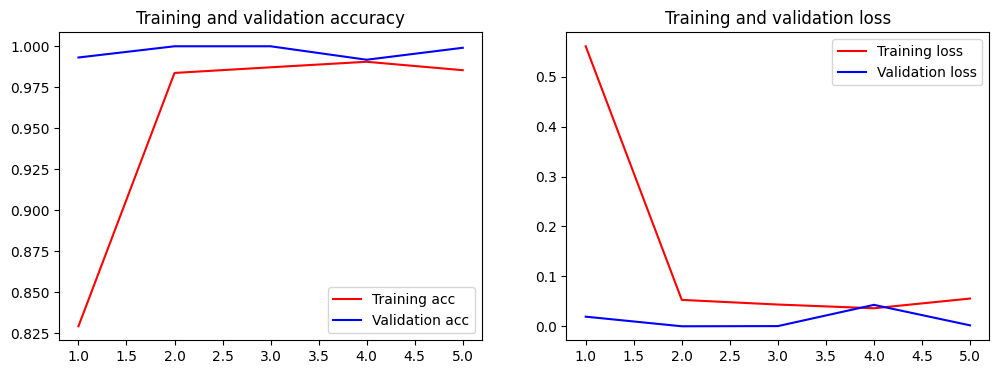

In [42]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(H)

# Konversi Model

Menyimpan model menjadi format .h5.

In [43]:
model.save("model.h5")

In [44]:
# Convert TFJS, model to TFJS format

!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-05-29 04:34:45.651810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748493285.691264   16346 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748493285.705636   16346 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [45]:
# Convert SavedModel

save_path = os.path.join("models/klasifikasi_gambar/1/")
tf.saved_model.save(model, save_path)

In [46]:
# Convert model to TFLITE format and save label.txt

# Load the Keras model
model_TFLITE = tf.keras.models.load_model('model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_TFLITE)
tflite_model = converter.convert()

# Save the converted model to a file
with open("converted_model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpvr8wkrpm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 23), dtype=tf.float32, name=None)
Captures:
  137377755477200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137377824651600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137377824646800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137377824642576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137377755473936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137377639644240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137377639641552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137377639642128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137377639642512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137377639640976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137377639641

In [52]:
content = """apple_golden_3
apple_red_1
apple_rotten_1
Avocado Green 1
Banana 3
Beans 1
Blackberrie 1
Cabbage red 1
cabbage_white_1
Cactus fruit red 1
Caju seed 1
carrot_1
Cherimoya 1
Cherry Rainier 3
Cherry Wax Red 2
Cucumber 5
eggplant_long_1
Gooseberry 1
pear_3
Pistachio 1
Quince 4
Tomato Cherry Maroon 1
zucchini_1"""

file_path = "/content/label.txt"

with open(file_path, "w") as file:
    file.write(content)

In [53]:
# Specify the folder to zip
folder_modles = '/content/models'
folder_tfjs_model = '/content/tfjs_model'

# Specify the output zip file name (without .zip extension)
output_modles= '/content/models'
output_tfjs_model = '/content/tfjs_model'

# Zip the folder
shutil.make_archive(output_modles, 'zip', folder_modles)
shutil.make_archive(output_tfjs_model, 'zip', folder_tfjs_model)

'/content/tfjs_model.zip'

In [49]:
!pip freeze > requirements.txt

## Inference

Melakukan inference terhadap model yang di deploy menggunakan tensorflow serving.

In [50]:
import tensorflow as tf
import requests
import os

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image: r1_254.jpg
Predicted Class: Cucumber 5
Confidence: 100.00%


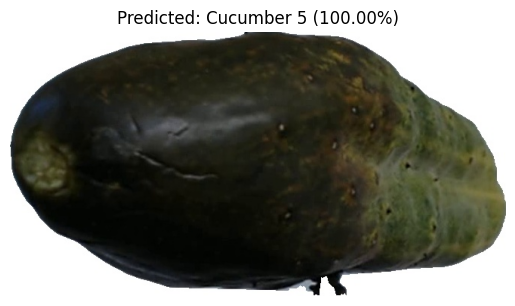

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Image: r2_255.jpg
Predicted Class: Cherimoya 1
Confidence: 100.00%


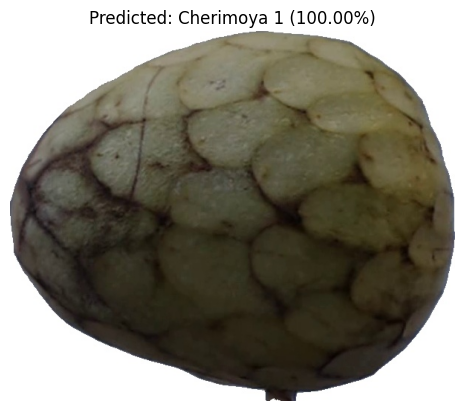

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Image: r0_269.jpg
Predicted Class: pear_3
Confidence: 100.00%


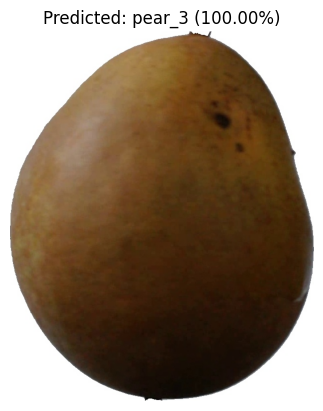

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Image: r0_102.jpg
Predicted Class: Banana 3
Confidence: 100.00%


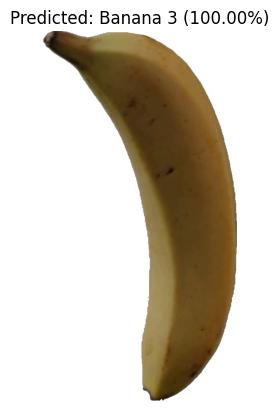

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Image: r1_198.jpg
Predicted Class: Tomato Cherry Maroon 1
Confidence: 100.00%


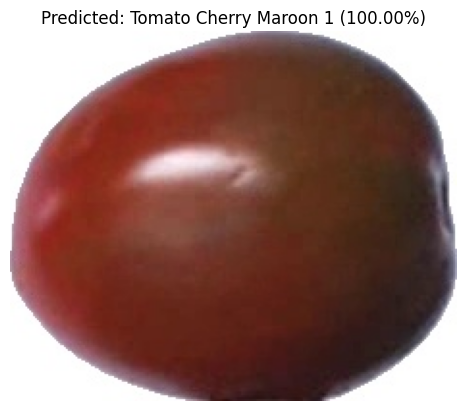

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Image: r0_103.jpg
Predicted Class: apple_rotten_1
Confidence: 100.00%


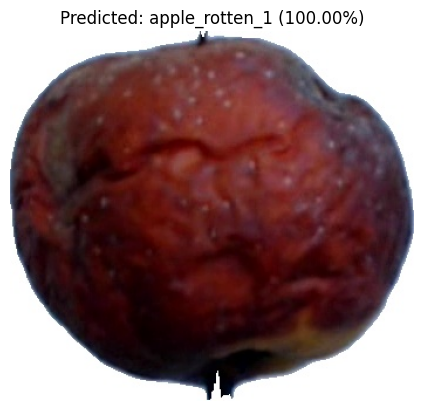

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Image: r0_44.jpg
Predicted Class: carrot_1
Confidence: 99.98%


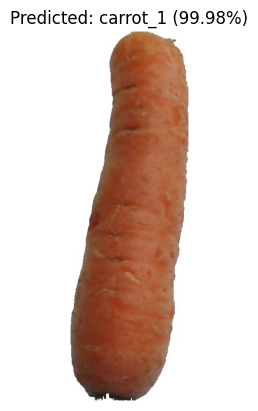

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Image: r0_10.jpg
Predicted Class: cabbage_white_1
Confidence: 100.00%


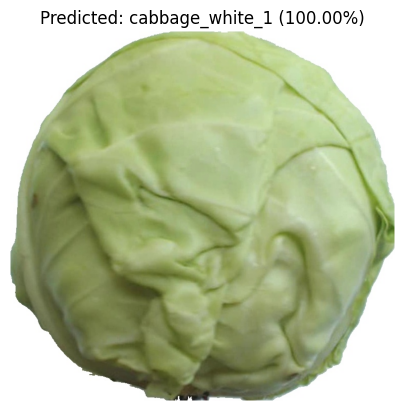

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Image: r1_195.jpg
Predicted Class: Blackberrie 1
Confidence: 100.00%


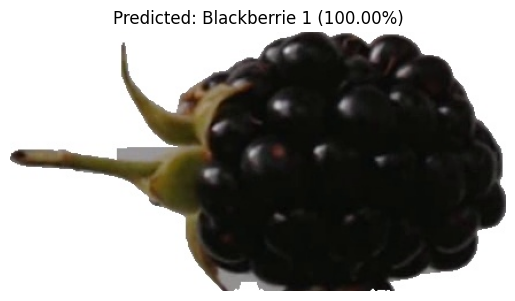

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Image: r0_81.jpg
Predicted Class: eggplant_long_1
Confidence: 100.00%


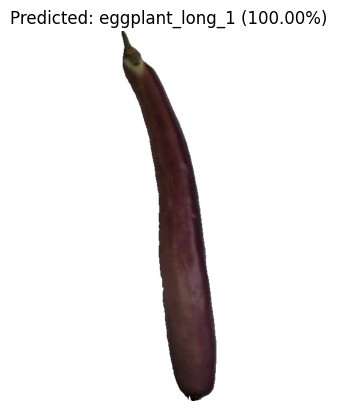

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Image: r0_35.jpg
Predicted Class: Caju seed 1
Confidence: 99.90%


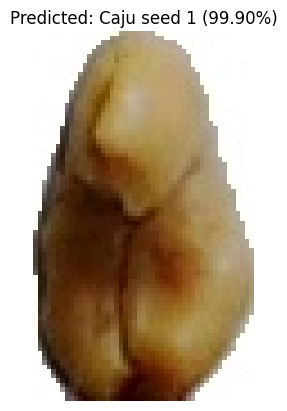

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Image: r2_222.jpg
Predicted Class: Pistachio 1
Confidence: 100.00%


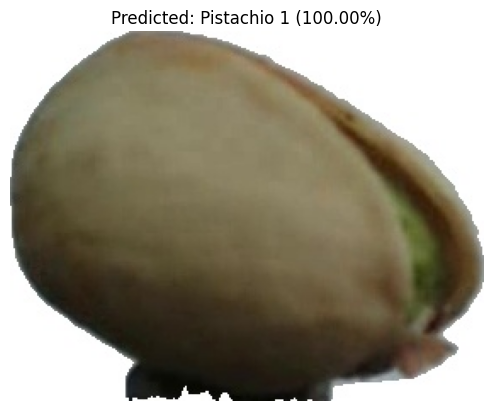

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Image: r0_273.jpg
Predicted Class: Cactus fruit red 1
Confidence: 100.00%


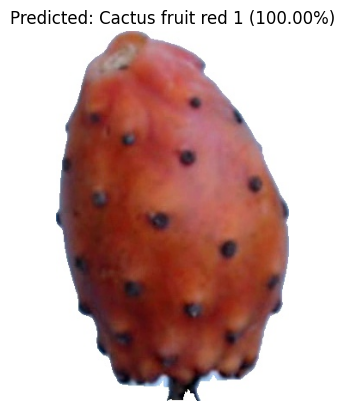

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Image: r1_181.jpg
Predicted Class: Cabbage red 1
Confidence: 100.00%


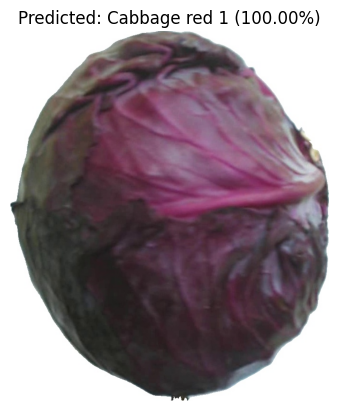

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Image: r1_83.jpg
Predicted Class: apple_red_1
Confidence: 100.00%


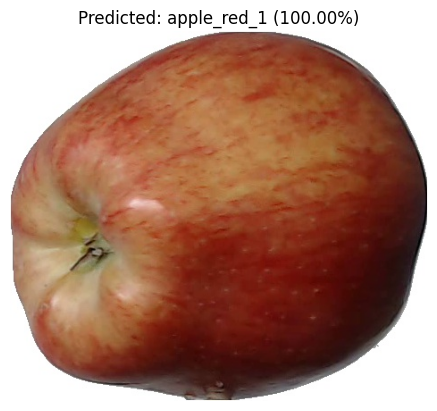

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Image: r0_234.jpg
Predicted Class: Gooseberry 1
Confidence: 100.00%


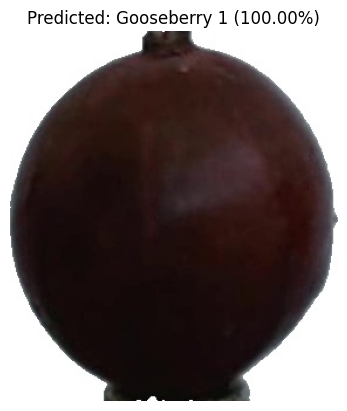

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Image: r0_51.jpg
Predicted Class: zucchini_1
Confidence: 100.00%


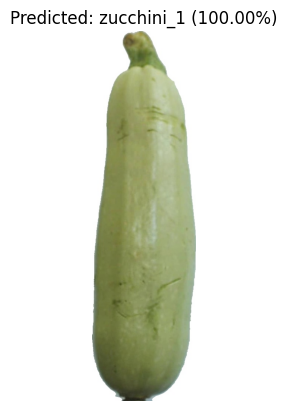

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Image: r0_289.jpg
Predicted Class: Avocado Green 1
Confidence: 100.00%


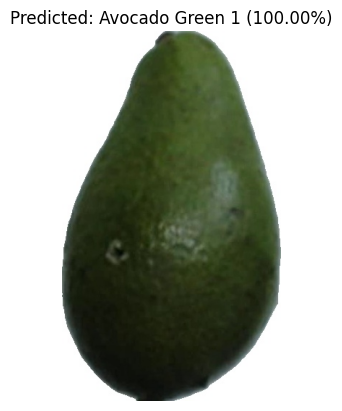

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Image: r1_294.jpg
Predicted Class: Cherry Wax Red 2
Confidence: 99.96%


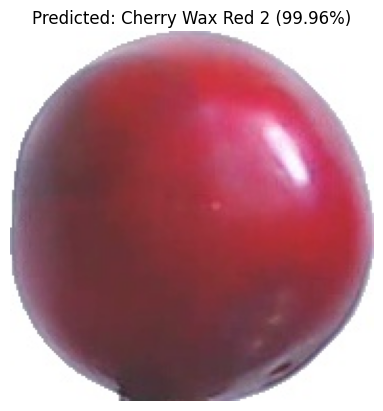

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Image: r1_239.jpg
Predicted Class: Beans 1
Confidence: 100.00%


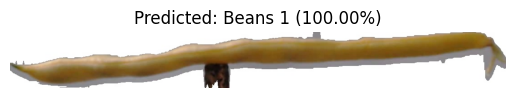

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Image: r2_140.jpg
Predicted Class: Cherry Rainier 3
Confidence: 100.00%


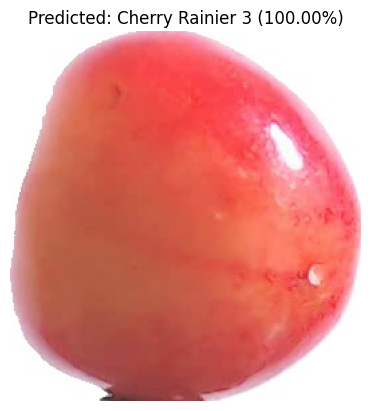

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Image: r1_40.jpg
Predicted Class: Quince 4
Confidence: 100.00%


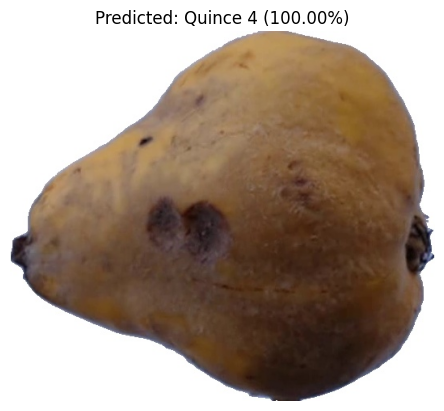

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Image: r1_162.jpg
Predicted Class: apple_golden_3
Confidence: 100.00%


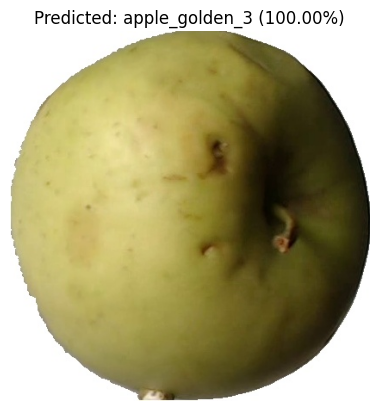

In [51]:
# predictions each class is tried by 1 image and show the image

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Dictionary to map class indices back to class names
# You need to get this from your train_generator.class_indices
# For example: class_indices = {'Apple 10': 0, 'Apple 11': 1, ..., 'Apple worm 1': 14}
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, img_size=(150, 150)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to make predictions and display the image
def predict_and_show(model, image_path, idx_to_class):
    img_array = load_and_preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = idx_to_class[predicted_class_index]
    confidence = np.max(predictions) * 100

    print(f"Image: {os.path.basename(image_path)}")
    print(f"Predicted Class: {predicted_class_name}")
    print(f"Confidence: {confidence:.2f}%")

    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

# Get one image path for each class from the test set
test_dir = '/content/dataset/test'
class_test_images = {}

for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        if images:
            class_test_images[class_name] = os.path.join(class_path, random.choice(images))

# Make predictions for one image per class
for class_name, image_path in class_test_images.items():
    predict_and_show(model, image_path, idx_to_class)
    print("=" * 75)